## word2vec 구현

1. 추론 기반의 기법
- 어떤 맥락 (주변 단어들)이 주어졌을 때, 그 사이에 들어갈 단어를 **추론**하기 위해 모델을 사용
- 이 때 사용되는 모델이 신경망이고, 그 신경망의 일종이 word2vec이다
- 추론 기반의 기법은 일반적으로 미니배치 방식을 사용해 전체 데이터의 일부만을 랜덤으로 반복해서 사용하여 모델을 학습한다
    - **통계 기반 기법의 단점**: 통계 기반 기법은 문서 내 출현하는 모든 단어들을 이용해서 동시출현 행렬을 생성하므로 단어의 개수만큼 행렬의 내부 데이터가 늘고 생성되는 행렬은 희소행렬이라는 문제점이 존재
    - 즉 데이터의 활용이 효율적이지 못하고 때문에 컴퓨팅 자원을 매우 많이 사용
    
2. 원-핫 벡터 표현
- 신경망을 이용한 자연어 처리에서는 원-핫 벡터를 이용하여 문서의 단어 출현을 표현함
- 이 때 원-핫 벡터로 표현된 단어의 출현들이 곧 뉴런이 된다    
    ex) 아래 그림과 같이 단어들의 원핫벡터들이 각각 입력층에 위치하게 됨
    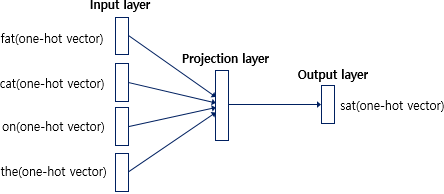

In [1]:
#입력층에서 은닉층으로의 순전파

#완전연결계층 과정 들여다보기

import numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) #입력층, 1*7 행렬
W = np.random.randn(7, 3) #은닉층, 7*3 행렬
h = np.matmul(c, W)
print(h)

[[-0.4218053  -0.08045368 -0.44548407]]


위의 완전연결계층의 순전파는 결국 입력층의 1로 입력된 단어에 종속되어서  
이에 해당하는 가중치의 행을 뽑는것과 동일함

In [3]:
#Matmul class를 이용한 완전연결계층 순전파 구현
import sys
from mh_common.mh_layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]])
W = np.random.randn(7, 3) 
layer = MatMul(W) #가중치 W를 담은 행렬곱 계층 생성
h = layer.forward(c)
print(h)

[[-1.33320981 -0.47348105 -0.53447159]]


## CBOW (Continous Bag-Of-Words)
- 맥락 단어표현 벡터를 입력층으로, 중간의 정답 단어를 출력층으로 하는 신경망
- **입력층**은 맥락에 포함시킬 단어의 개수에 따라 달라짐(즉 윈도우 사이즈에 따라서 입력층의 크기가 달라짐)           
    ex) 윈도우 사이즈가 3이면 맥락 단어의 개수가 6이므로, 입력층의 개수도 6이 될 것
- **은닉층**은 입력층 개수의 평균을 취하면 됨. 즉 입력층 순전파로 생성된 h들을 sum하여 입력층의 개수 N으로 나누는 평균을 취함
- **출력층**은 입력층과 동일한 뉴런의 구조를 취하고 이 때 각 뉴런이 취하는 값은 점수, 출현 확률로 표기가 됨. 출력층 뉴런들의 값을 얻기 위해서 Softmax 계층을 이용함

<br/> 

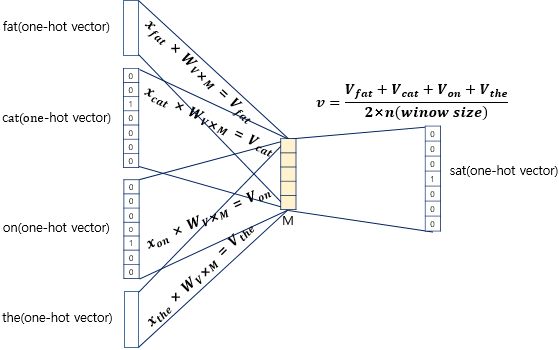

In [4]:
#위 그림에 제시된 완전연결계층 CBOW를 구현해보기

#입력층이 2개, 즉 윈도우 크기가 1일 때의 경우의 완전연결계층 순전파

#입력층 2, 윈도우 크기 1
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]]) #1*7행렬
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

#가중치 초기화
W_in = np.random.randn(7, 3) #입력층 -> 은닉층, 7*3행렬
W_out = np.random.randn(3, 7) #은닉층 -> 출력층, 3*7행렬

#계층 생성
in_layer0 = MatMul(W_in) #입력층 -> 은닉층은 가중치를 공유함
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

#순전파
h0 = in_layer0.forward(c0) #1*3 행렬
h1 = in_layer1.forward(c1) #1*3 행렬
h = 0.5 * (h0 + h1)
s = out_layer.forward(h) #1*7 행렬, 입력층과 동일한 구조

print(s) #어떤 점수를 생성함

[[ 0.79782915 -1.81306264 -0.91981535  1.45838316  1.03482346 -1.42635236
   0.97256051]]


출력층에서 생성된 어떤 점수는 최종적으로 SoftmaxWithLoss 계층을 이용하여
1) 먼저 SoftMax 확률 값을 생성하고    
2) 정답 데이터를 이용하여 crossentropy 손실을 이용하여 Loss를 생성한다     
3) 생성된 Loss를 바탕으로 역전파를 하여 모델의 가중치를 학습한다     
      
이 과정은 아래 그림과 같다

<br/> 

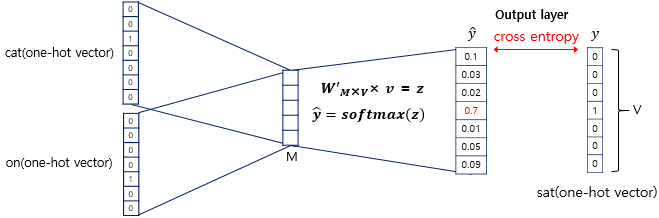

## CBOW 모델 구현을 위한 학습 데이터 생성하기

### 1. corpus 생성

In [1]:
import sys
import numpy as np

from mh_common.mh_utils import preprocess

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

print(corpus) #문장, 문서의 출현 단어들을 정수 인덱싱으로 변환하여 표현한것

print(id_to_word) #출현하는 단어들의 정수 인덱싱을 키로, 값은 단어들로

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [2]:
corpus[1:-1]

array([1, 2, 3, 4, 1, 5])

In [3]:
corpus[2:-2]

array([2, 3, 4, 1])

### 2. contexts, target 행렬 생성

In [4]:
#create_contexts_target 함수 작동방식 이해하기

#맥락을 추출하는 방법 (윈도우 크기가 1인 경우에)

#먼저 총 맥락이 선택될 수 있는 인덱스는 처음 target을 추출하는 인덱스와 같다

window_size = 1
for idx in range(window_size, len(corpus) - window_size):
    print(idx)
    
#그 다음 타겟 층마다 맞는 맥락을 선택하기 위해서 윈도우의 작동방식을 이용한다
contexts = []

for idx in range(window_size, len(corpus) - window_size):
    print(idx, corpus[idx])
    cs = []
    for t in range(-window_size, window_size + 1):
        if t== 0: #target이 해당하는 위치는 건너뛴다
            continue 
        cs.append(corpus[idx + t])
    print(cs)
    contexts.append(cs)

1
2
3
4
5
6
1 1
[0, 2]
2 2
[1, 3]
3 3
[2, 4]
4 4
[3, 1]
5 1
[4, 5]
6 5
[1, 6]


In [5]:
from mh_common.mh_utils import create_contexts_target

contexts, target = create_contexts_target(corpus, window_size = 1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


In [8]:
contexts.shape

(6, 2)

### 3. contexts, target을 one-hot encoding하기

In [9]:
len(word_to_id) #유일하게 등장하는 단어들의 개수

7

In [15]:
target.shape[0] #target, contexts의 행 수

6

In [16]:
np.zeros((6, 7))

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]])

In [17]:
#target의 원소들의 위치와 원소 값
for idx, word_id in enumerate(target):
    print(idx, word_id)

0 1
1 2
2 3
3 4
4 1
5 5


In [19]:
#contexts의 경우
contexts.ndim

2

In [20]:
contexts.shape[0]

6

In [23]:
np.zeros((contexts.shape[0], contexts.shape[1], len(word_to_id)))
    #2행 7열 짜리 행열을 6개 가진 3차원 행렬
    #원래 contexts의 열의 개수가 곧 맥락의 개수와 동일하므로
    #맥락을 one-hot encoding으로 표현하기 위해 행의 개수로 변환되고
    #원래 contexts의 행의 개수는 총 맥락의 개수를 표현하기 위해 2차원 행렬의 개수인 6으로 표현 

array([[[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]]])

In [27]:
contexts

array([[0, 2],
       [1, 3],
       [2, 4],
       [3, 1],
       [4, 5],
       [1, 6]])

In [29]:
for idx_0, word_ids in enumerate(contexts):
    print(idx_0, word_ids) #첫 고정되는 idx_0은 contexts의 행
    for idx_1, word_id in enumerate(word_ids):
        print(idx_1, word_id) #다음 고정되는 기준은 

0 [0 2]
0 0
1 2
1 [1 3]
0 1
1 3
2 [2 4]
0 2
1 4
3 [3 1]
0 3
1 1
4 [4 5]
0 4
1 5
5 [1 6]
0 1
1 6


In [1]:
#학습데이터를 얻는 전 과정을 구현하기

from mh_common.mh_utils import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

In [2]:
target

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]])

In [3]:
contexts

array([[[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]],

       [[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]]])

## CBOW 모델 구현하기 (간단한 CBOW 모델 구현)

**역전파 계산 그래프 이해**

<br/> 
13분 38초 부터    

https://www.youtube.com/watch?v=AqBmB5DJqWg&ab_channel=KyungHoonHan

In [2]:
#CBOW 순전파 구현
#2층 입력 구조를 가진 간단한 CBOW모델 구현

from mh_common.mh_layers import MatMul, SoftmaxWithLoss
import numpy as np

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        #가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') #32비트 부동소수점 수로 초기화
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        #계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        #모든 계층을 layers에 담는다
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        
        self.params, self.grads = [], []
        
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        self.word_vecs = W_in
    
    #순전파 구현
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        #contexts 6*2*7행렬의 0번째 원소들은 6*7 행렬로 추출이 되고
        #이를 7*3 행렬과 행렬곱을 실시하면 output은 6*3 행렬
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = 0.5 * (h0 + h1)
        score = self.out_layer.forward(h) 
        #6*3 행렬과 3*7 W_out행렬을 행렬곱 하여
        #최종적으로 6*7 행렬을 출력층으로 
        loss = self.loss_layer.forward(score, target)
        #최종 출력층 6*7행렬과 target값을 비교하여서 손실 loss를 산출
        return loss
    
    #역전파 구현
    def backward(self, dout = 1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

In [5]:
contexts[:, 0] #3차원 행렬 내 2차원 행렬들의 첫번째 행들만 추출한 것
    #따라서 행렬의 형태는 6 * 7 행렬이 됨
    #이러한 표현은 window_size가 1일 때 앞의 맥락에 해당이 됨
    #따라서 h1은 window_size가 1일 때의 앞 맥락의 입력값들과 가중치의 행렬곱이 이뤄진 결과물

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.]])

In [6]:
contexts

array([[[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0.]],

       [[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]],

       [[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.]],

       [[0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]],

       [[0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.]]])

## SimpleCBOW 모델 학습 구현

| epoch 1 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 2 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 3 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 4 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 5 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 6 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 7 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 8 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 9 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 10 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 11 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.95
| epoch 12 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 13 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 14 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 15 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 16 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 17 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 18 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 1.94
| epoch 19 | mini-b

| epoch 409 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.83
| epoch 410 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.76
| epoch 411 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.83
| epoch 412 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.69
| epoch 413 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.63
| epoch 414 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.83
| epoch 415 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.76
| epoch 416 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.75
| epoch 417 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.62
| epoch 418 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.94
| epoch 419 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.82
| epoch 420 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.63
| epoch 421 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.81
| epoch 422 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.69
| epoch 423 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.80
| epoch 424 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.69
| epoch 425 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.80
| epoch 426 | mini-batch 1 / 2 | 시간 0[s] |avg_lo

| epoch 831 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.71
| epoch 832 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.56
| epoch 833 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.59
| epoch 834 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.62
| epoch 835 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.46
| epoch 836 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.51
| epoch 837 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.57
| epoch 838 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.65
| epoch 839 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.75
| epoch 840 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.51
| epoch 841 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.57
| epoch 842 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.53
| epoch 843 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.50
| epoch 844 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.64
| epoch 845 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.55
| epoch 846 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.51
| epoch 847 | mini-batch 1 / 2 | 시간 0[s] |avg_loss 0.57
| epoch 848 | mini-batch 1 / 2 | 시간 0[s] |avg_lo

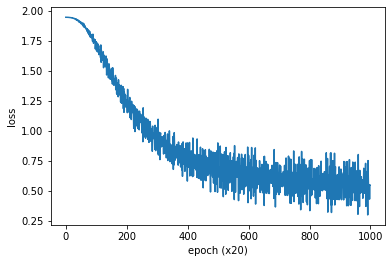

In [3]:
import sys

from mh_common.mh_trainer import Trainer
from mh_common.mh_utils import preprocess, create_contexts_target, convert_one_hot
from mh_common.mh_optimizer import Adam

window_size = 1
hidden_size = 5 #은닉층이 5차원
batch_size = 3 #3개씩 묶어서 처리
max_epoch = 1000 #총 훈련횟수

text = 'You say goodbye and I say hello.'

corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)

contexts, target = create_contexts_target(corpus, window_size)

target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [12]:
word_vecs = model.word_vecs

for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-0.79491895  1.4387132  -1.1063938   1.3151796  -0.71905875]
say [0.6645706  0.31054783 1.2431974  0.18131456 1.2198406 ]
goodbye [-1.0830855   0.21237843 -0.7197108   0.58105206 -1.10641   ]
and [ 1.3107587 -1.4088876  1.0769827  1.4719585  1.0407794]
i [-1.1021003   0.1920586  -0.71211016  0.5763213  -1.108476  ]
hello [-0.807965   1.455222  -1.0833703  1.3224881 -0.7204236]
. [-1.4534365  1.2197577  1.0934016 -1.2633251  1.072363 ]


### optimizer에 사용되는 Adam 은 무엇인가?
    - Momentum, AdaGrad는 무엇인가?
    
#### Momentum
https://www.youtube.com/watch?v=TQmCLe1BCJk&t=3823s&ab_channel=KyungHoonHan   
- SGD의 개념에 더하여 물리계의 **관성 개념**을 추가
- 즉 관성이 크다면 SGD와 달리 local minimum에 매몰되지 않고 global minimum에 도달할 수 있다
    
**점화식**     

### $v_n = \alpha v_{n-1} - \eta \triangledown f(x_n), v_{-1} = 0$  
### $x_{n+1} = x_n + v_n$

- $\alpha$ 는 관성계수    
- $\eta$ 는  학습률, learning rate     
- $\triangledown f(x_n)$는 편미분, 즉 $f(x,y) = xy$일 때 $\triangledown f(x,y) = (y,x)$
- 초기의 갱신값은 SGD와 동일함. 초기 속도인 $v_{-1} = 0$ 이기 때문에

코드는 mh_optimzer.py에 작성하였음

#### AdaGrad    
https://www.youtube.com/watch?v=s8dzhdJ3fqg&ab_channel=KyungHoonHan 
- SGD는 매 update 마다 동일한 learning rate를 사용하는데 
- AdaGrad는 변수마다, 스텝마다 **다른 learning rate**를 사용하게 된다
    - 초기 learning rate를 크게하고 대신 스텝이 지날수록 learning rate를 작게 한다
    - 변수 관점에서는 큰 변화를 겪은 변수의 learning rate는 대폭 작아지게 하고
    - 작은 변화를 겪은 변수는 learning rate를 소폭 작아지게 한다
    - 이는 큰 변화를 겪은 변수 (편미분의 절대값이 큰 경우)는 최적에 다다렀다고 가정하고 
    - 반대로 작은 변화를 겪은 변수 (편미분의 절대값이 작은 경우)는 아직 최적에 다다르지 못했다고 가정하기 때문

**점화식**     
### $h_n = h_{n-1} + \triangledown f(x_n) \odot \triangledown f(x_n), h_{-1} = 0$
### $x_{n+1} = x_n - \eta \frac{1}{\sqrt{h_n}} \odot \triangledown f(x_n)$
- $\odot$은 행렬들간의 원소별 곱을 의미하는 것
- $\triangledown f(x_n) \odot \triangledown f(x_n)$는 원소들을 제곱한 개념
    - 만약 편미분 절대 값이 크다면 $\triangledown f(x_n) \odot \triangledown f(x_n)$ 값도 클 것이고 작은 경우는 그 역일것
- 실질적인 learning rate는 $\eta \frac{1}{\sqrt{h_n}}$가 되는것, 때문에 매 step마다 learning rate가 달라짐
    - $h_n$은 step마다 커질 수 밖에 없으므로 step마다  $\eta \frac{1}{\sqrt{h_n}}$은 작아질 수 밖에 없을것
    
### RMSProp
https://www.youtube.com/watch?v=s8dzhdJ3fqg&ab_channel=KyungHoonHan
- AdaGrad는 step이 지남에 따라 $h_n$이 너무 커져서 학습이 되지 않는 문제가 발생
- 이러한 문제를 해결하기 위해 등장한 방법이 RMSProp
- $\gamma$ 를 추가하여 가중치 평균(내분)을 반영하도록 한다
### $h_n = \gamma h_{n-1} + (1- \gamma) \triangledown f(x_n) \odot \triangledown f(x_n), h_{-1} = 0$
### $x_{n+1} = x_n - \eta \frac{1}{\sqrt{h_n}} \odot \triangledown f(x_n)$
    - $\gamma$값이 클수록 $h_{n-1}$인 과거의 값을 중요하게 여기게 되고, 
    - 반대인 경우에는 현재의 값인 $\triangledown f(x_n) \odot \triangledown f(x_n)$을 중요하게 여기게 된다
    
    
### Adam
https://www.youtube.com/watch?v=mJbSrujKmGs&ab_channel=KyungHoonHan
- 여려 경우에서 좋은 성능을 보여주는 optimizer
- Momentum, RMSProp의 개념을 이용

**점화식**
### $m_n = \beta_{1} m_{n-1} + (1-\beta_{1})\triangledown f(x_n)$,   $m_{-1} = 0$
    - Momentum의 관성계수를 반대로 사용한 경우가 베타1
### $v_n = \beta_{2} v_{n-1} + (1 - \beta_{2})\triangledown f(x_n) \odot \triangledown f(x_n)$,   $v_{-1} = 0$
    - RMSProp의 감마에 대응되는 값이 베타2

최종식은 $m_n, v_n$을 보정한 값을 사용하여 작성한다

### $\hat{m_n} = \frac {m_n}{1 - \beta_{1}^{n+1}}$, $\hat{v_n} = \frac {v_n}{1 - \beta_{2}^{n+1}}$

### $x_{n+1} = x_n - \eta \frac{1}{\sqrt{\hat{v_n}}} \odot \hat{m_n}$
